In [141]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

from cycler import cycler

from tueplots import figsizes
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("colorblind")

plt.rcParams.update({"figure.dpi": 150})

# set via 'ax.set_prop_cycle(line_cycler)'
line_cycler = (cycler(linestyle=["-", "--", "-.", ":", "-"]))
marked_line_cycler = (cycler(color=sns.color_palette("colorblind")[:4]) +
                      cycler(linestyle=["-", "--", "-.", ":"]) +
                      cycler(marker=["", "^", ".", "x"]))

import sys
sys.path.insert(0,'../src/')

import jump_diffusion_process as jdp
import markov_decision_process as mdp
import util

import glob
import re
import os

In [5]:
rng = default_rng()

fig_dir = "../fig/"

# Experiment 1: Approximation Quality

In [9]:
res_dir = "results_optimality_experiment/"

In [6]:
import optimality_experiment as optex

In [7]:
pmf, realizations = optex.pseudonormal_pmf()

In [ ]:
if os.path.isfile(res_dir + "V_fin_opt_pseudonormal.npy"):
    V_fin_opt = np.load(res_dir + "V_fin_opt_pseudonormal.npy")
    pol_fin_opt = np.load(res_dir + "pol_fin_opt_pseudonormal.npy")
else:
    V_fin_opt, pol_fin_opt = optex.finite_support_optimal_solution(realizations, pmf)
    np.save(res_dir + "V_fin_opt_pseudonormal.npy", V_fin_opt)
    np.save(res_dir + "pol_fin_opt_pseudonormal.npy", pol_fin_opt)

In [101]:
V_fin, pol_fin = optex.finite_support_badp_lattice(realizations, pmf, seed=100)

In [135]:
paths = optex.finite_support_price_process(1000, 25, realizations, pmf, seed=3000)

In [136]:
dec_fin_opt, act_fin_opt, inv_fin_opt, rew_fin_opt = optex.simulate_finite_support_policy(pol_fin_opt, paths.T)
dec_fin, act_fin, inv_fin, rew_fin = optex.simulate_finite_support_policy(pol_fin, paths.T)

In [137]:
perc_optimality = rew_fin.sum(axis=0).mean() / rew_fin_opt.sum(axis=0).mean()
print(f"BADP-lattice achieves {perc_optimality * 100: .2f}% optimality.")

BADP-lattice achieves  92.34% optimality.


In [138]:
cum_rews_pseudonormal = np.vstack([rew_fin.sum(axis=0), rew_fin_opt.sum(axis=0)])

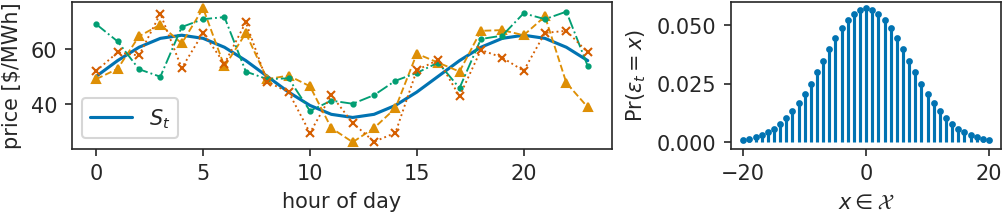

In [139]:
det_part = np.array([optex.deterministic_part(t) for t in range(24)])

plt.rcParams.update(figsizes.aistats2023_full(nrows=1, ncols=2, height_to_width_ratio=.44))

fig, axs = plt.subplots(ncols=2, width_ratios=[2, 1])

inds = rng.integers(0, 999, size=3)

axs[0].set_prop_cycle(marked_line_cycler)
axs[0].plot(det_part, label="$S_t$", ls="solid", marker="")
axs[0].set_xlabel("hour of day")
axs[0].set_ylabel("price [\$/MWh]")

axs[0].plot(paths[inds, :-1].T, markersize=4, lw=.9)
axs[0].legend()

axs[1].scatter(realizations, pmf, s=5)
axs[1].vlines(realizations, 0, pmf)
axs[1].set_xlabel("$x \in \mathcal{X}$")
axs[1].set_ylabel("$\Pr(\epsilon_t = x)$")

fig.savefig(fig_dir + "finite_support_price_process.png")

plt.show()

## With uniform distribution

In [142]:
pmf, realizations = optex.uniform_pmf()

In [144]:
if os.path.isfile(res_dir + "V_fin_opt_uniform.npy"):
    V_fin_opt = np.load(res_dir + "V_fin_opt_uniform.npy")
    pol_fin_opt = np.load(res_dir + "pol_fin_opt_uniform.npy")
else:
    V_fin_opt, pol_fin_opt = optex.finite_support_optimal_solution(realizations, pmf)
    np.save(res_dir + "V_fin_opt_uniform.npy", V_fin_opt)
    np.save(res_dir + "pol_fin_opt_uniform.npy", pol_fin_opt)

In [145]:
V_fin, pol_fin = optex.finite_support_badp_lattice(realizations, pmf, seed=100)

In [146]:
paths = optex.finite_support_price_process(1000, 25, realizations, pmf, seed=3000)

In [147]:
dec_fin_opt, act_fin_opt, inv_fin_opt, rew_fin_opt = optex.simulate_finite_support_policy(pol_fin_opt, paths.T)
dec_fin, act_fin, inv_fin, rew_fin = optex.simulate_finite_support_policy(pol_fin, paths.T)

In [148]:
perc_optimality = rew_fin.sum(axis=0).mean() / rew_fin_opt.sum(axis=0).mean()
print(f"BADP-lattice achieves {perc_optimality * 100: .2f}% optimality.")

BADP-lattice achieves  97.15% optimality.


In [149]:
cum_rews_uniform = np.vstack([rew_fin.sum(axis=0), rew_fin_opt.sum(axis=0)])

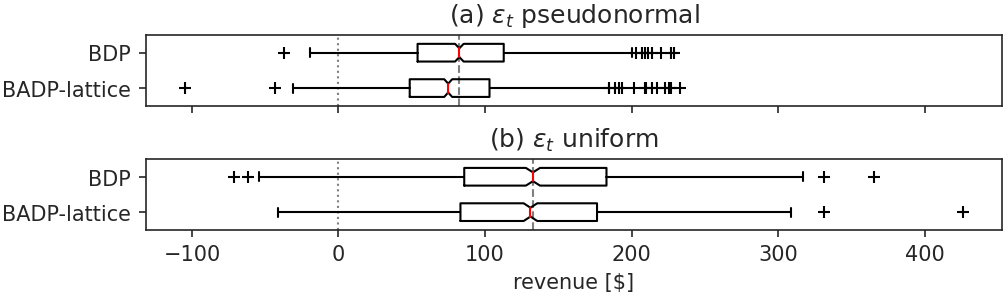

In [151]:
plt.rcParams.update(figsizes.aistats2023_full(nrows=2, ncols=1, height_to_width_ratio=.15))
fig, axs = plt.subplots(nrows=2, sharex=True)

# pseudonormal
combs = np.arange(cum_rews_pseudonormal.shape[0]) + 1

lw = 1

axs[0].axvline(np.median(cum_rews_pseudonormal[1]), linestyle="dashed", color="tab:gray", lw=lw)
axs[0].axvline(0, color="tab:gray", ls="dotted", lw=lw)
bp = axs[0].boxplot(cum_rews_pseudonormal.T,
                    notch=True,
                    sym='k+',
                    vert=False,
                    widths=.5,
                    positions=combs,
                    boxprops=dict(lw=lw),
                    whiskerprops=dict(lw=lw),
                    flierprops=dict(lw=lw),
                    capprops=dict(lw=lw))

for median in bp['medians']:
    median.set_color('red')

axs[0].set_yticklabels(["BADP-lattice", "BDP"])
axs[0].set_title("(a) $\epsilon_t$ pseudonormal")


axs[1].axvline(np.median(cum_rews_uniform[1]), linestyle="dashed", color="tab:gray", lw=lw)
axs[1].axvline(0, color="tab:gray", ls="dotted", lw=lw)
bp = axs[1].boxplot(cum_rews_uniform.T,
                    notch=True,
                    sym='k+',
                    vert=False,
                    widths=.5,
                    positions=combs,
                    boxprops=dict(lw=lw),
                    whiskerprops=dict(lw=lw),
                    flierprops=dict(lw=lw),
                    capprops=dict(lw=lw))

axs[1].set_yticklabels(["BADP-lattice", "BDP"])
axs[1].set_title("(b) $\epsilon_t$ uniform")

for median in bp['medians']:
    median.set_color('red')

plt.xlabel("revenue [\$]")

fig.savefig(fig_dir + "finite_support_boxplot_horizontal.png")

plt.show()

# Experiment 2: NYISO real-time dispatch market

In [152]:
W_TRAIN = 1000
W_TEST = 1000
STAGES = 24
SETTLEMENTS = 12


R_MIN = 0
R_MAX = 60
R = np.arange(R_MIN, R_MAX + 1)

EFF_DISCHARGE = .9
EFF_CHARGE = .9

In [153]:
prices = util.load_nyiso_rtd()

P_MIN, P_MAX = np.quantile(prices, [.025, .975])
print(f"95% of prices lie within the interval [{P_MIN}, {P_MAX}].")
print(f"We use this as lower and upper limits for sampling the price and bid spaces.")

# last price at time 22:50, s.t. test_paths starts at 22:55
p0 = prices[-15]  # prices[-2]
p0_ts = prices.index[-15]  # prices.index[-2]

sim_p0 = prices[-2]
sim_p0_ts = prices.index[-2]

95% of prices lie within the interval [-9.99, 103.44974999999977].
We use this as lower and upper limits for sampling the price and bid spaces.


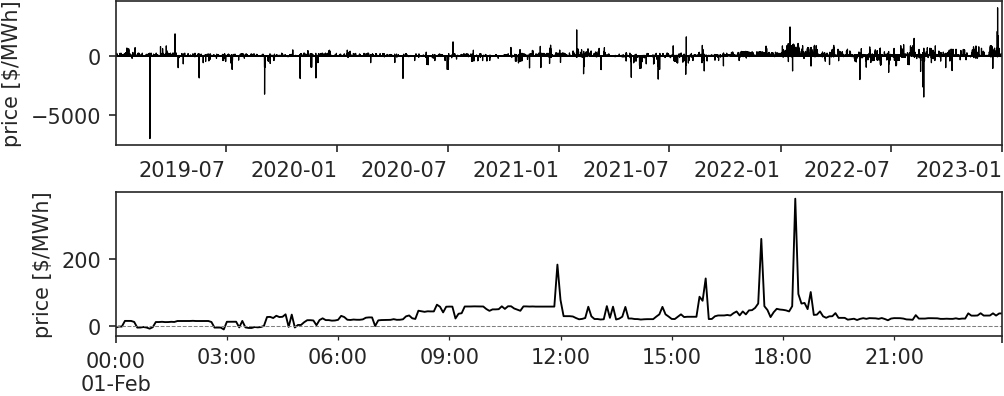

In [154]:
plt.rcParams.update(figsizes.aistats2023_full(nrows=2, ncols=1, height_to_width_ratio=.2))

fig, axs = plt.subplots(nrows=2)

axs[0].set_ylabel("price [\$/MWh]")
axs[1].set_ylabel("price [\$/MWh]")

prices.plot(lw=.6, ax=axs[0], rot=0, c="k")
axs[0].set_xmargin(0)

prices.loc["2021-02-01"].plot(lw=.9, ax=axs[1], c="k")

axs[1].axhline(0, lw=.5, c="tab:gray", ls="dashed")

axs[0].set_xlabel(None)
axs[1].set_xlabel(None)

plt.show()

## Calibrate Poisson Spike Process

In [155]:
jdp_, p_hat = jdp.PoissonSpikeProcess(scale=50).fit(prices, ret_despiked_p=True)

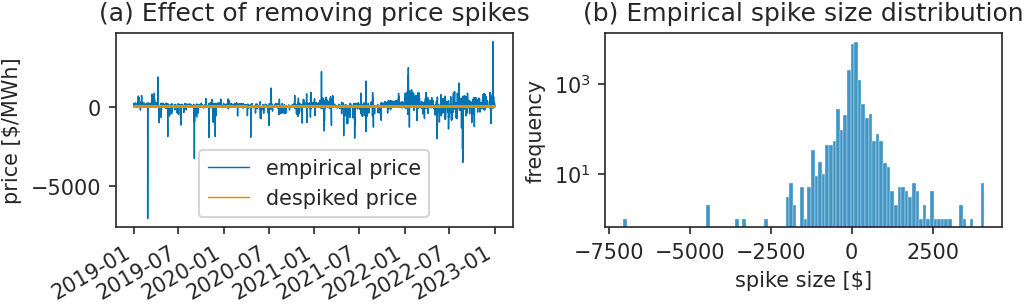

In [156]:
plt.rcParams.update(figsizes.aistats2023_full(nrows=1, ncols=2, height_to_width_ratio=.62))

fig, axs = plt.subplots(nrows=1, ncols=2, width_ratios=[1, 1])

emp_spike_distr = jdp_._params[3]

lw = .7
prices.plot(ax=axs[0], lw=lw, label="empirical price")
p_hat.plot(ax=axs[0], lw=lw, label="despiked price")
axs[0].set_ylabel("price [\$/MWh]")
axs[0].set_title("(a) Effect of removing price spikes")
axs[0].set_xlabel(None)
axs[0].legend()

sns.histplot(emp_spike_distr, ax=axs[1], bins=100, log=True)
axs[1].set_xlabel("spike size [\$]")
axs[1].set_ylabel("frequency")
axs[1].set_title("(b) Empirical spike size distribution")

plt.show()

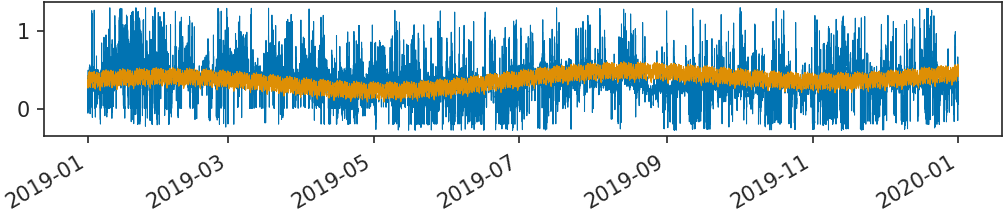

In [157]:
tf = jdp_._tf
ads = jdp_._ads

plt.rcParams.update(figsizes.aistats2023_full(nrows=1, ncols=1, height_to_width_ratio=.22))
fig, ax = plt.subplots()

p_tr = tf.transform(p_hat)
p_s = ads.get_seasonality(p_tr)

p_tr.loc["2019"].plot(ax=ax, lw=.5, label="$\sinh^{-1}(\hat{P}/30)$")
p_s.loc["2019"].plot(ax=ax, lw=.5, label="$S_t$")

ax.set_xlabel(None)

plt.show()


### Evaluate fit 

In [158]:
jdp_._params

(0.12069010079798204,
 0.024245756425777785,
 0.14203962831685044,
 array([-39.70804375, 112.78614109, 220.91555139, ..., -47.31858547,
        -43.83875459, 207.43867442]),
 0.04998074738188162)

In [163]:
p_start = prices[0]
ts_start = prices.index[0] - pd.Timedelta(minutes=5)

test_paths = jdp_.simulate(250, len(prices), p_start, ts_start, freq="5T", seed=100)
test_paths.index = prices.index

In [164]:
N = test_paths.shape[1]

mean = test_paths.values.mean().mean()
std = test_paths.values.std().mean()
skew_ = skew(test_paths.values, axis=0).mean()
kurt = kurtosis(test_paths.values, axis=0).mean()
max_ = test_paths.values.max(axis=0).mean()
min_ = test_paths.values.min(axis=0).mean()

data = np.array([[prices.mean(), mean], 
                 [prices.std(), std],
                 [skew(prices), skew_],
                 [kurtosis(prices), kurt],
                 [prices.max(), max_],
                 [prices.min(), min_]])

stat_props =  pd.DataFrame(data=data.T,
                           index=["empirical", "simulation"],
                           columns=["mean", "std", "skewness", "kurtosis", "max", "min"])
stat_props

,mean,std,skewness,kurtosis,max,min
empirical,25.908055,57.134528,3.750514,1575.373978,4116.90000,-7033.77000
simulation,25.812399,56.886495,3.650435,1614.175807,4110.12264,-6171.53128


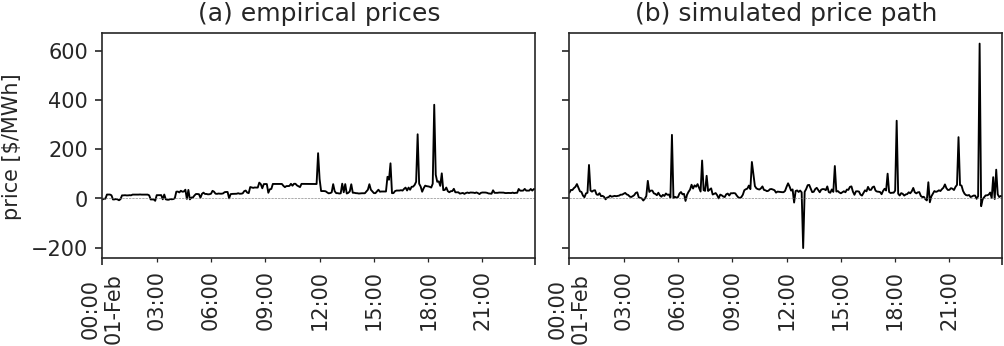

In [173]:
inds = 200
day = "2021-02-01"

year_lw = .3
day_lw = .9

plt.rcParams.update(figsizes.aistats2023_full(nrows=1, ncols=2, height_to_width_ratio=.7))

fig, axs = plt.subplots(ncols=2, sharey=True)

axs[0].set_ylabel("price [\$/MWh]")

prices.loc[day].plot(lw=day_lw, ax=axs[0], c="k", rot=90)

axs[0].axhline(0, ls="dashed", c="tab:gray", lw=.3)
axs[0].set_ylabel("price [\$/MWh]")

test_paths.loc[day].iloc[:, inds].plot(ax=axs[1], lw=day_lw, legend=False, c="k", rot=90)
axs[1].axhline(0, ls="dashed", c="tab:gray", lw=.3)


axs[0].set_xlabel(None)
axs[1].set_xlabel(None)

axs[0].set_title("(a) empirical prices")
axs[1].set_title("(b) simulated price path")

fig.savefig(fig_dir + "empirical_vs_simulated.png")

plt.show()

## Consider effect of sampling on policy value

In [174]:
res_dir = "results_sampling_experiment/"

In [175]:
test_paths = pd.read_csv(res_dir + "sampling_experiment_test_paths.csv", index_col=0)

In [176]:
# |B|
pf_nums = []
pf_pat = "perfect_foresight_len_B_(\d+).npy"
pf_files = glob.glob(res_dir + "perfect_foresight_len_B_*.npy")

pf_rews = np.full((len(pf_files), STAGES * SETTLEMENTS, W_TEST), np.nan)

for i, f in enumerate(pf_files):
    groups = re.findall(pf_pat, f)
    b_num = int(groups[0])

    pf_nums.append(b_num)

    pol = np.load(f)
    _, _, _, pf_rews[i] = mdp.simulate_pf_policy(pol, test_paths)

In [177]:
# |B|
b_nums = []
b_pat = "pol_STAGES_24_W_1000_k50_R_61_P_(\d+)_B_(\d+).npy"
b_files = glob.glob(res_dir + "pol_STAGES_24_W_1000_k50_R_61_P_1_B_*.npy")

b_rews = np.full((len(b_files), STAGES * SETTLEMENTS, W_TEST), np.nan)

for i, f in enumerate(b_files):
    groups = re.findall(b_pat, f)[0]
    p_num = int(groups[0])
    b_num = int(groups[1])

    _, B, P = mdp.create_sampled_spaces(P_MIN, P_MAX, b_num=b_num, p_num=p_num)

    b_nums.append(b_num)

    pol = np.load(f)
    _, _, _, b_rews[i] = mdp.simulate_policy(pol, test_paths, p0, P, B)

In [178]:
# |P|
p_nums = []
p_pat = "pol_STAGES_24_W_1000_k50_R_61_P_(\d+)_B_(\d+).npy"
p_files = glob.glob(res_dir + "pol_STAGES_24_W_1000_k50_R_61_P_*_B_10.npy")

p_rews = np.full((len(p_files), STAGES * SETTLEMENTS, W_TEST), np.nan)

for i, f in enumerate(p_files):
    groups = re.findall(p_pat, f)[0]
    p_num = int(groups[0])
    b_num = int(groups[1])

    _, B, P = mdp.create_sampled_spaces(P_MIN, P_MAX, b_num=b_num, p_num=p_num)

    p_nums.append(p_num)

    pol = np.load(f)
    _, _, _, p_rews[i] = mdp.simulate_policy(pol, test_paths, p0, P, B)


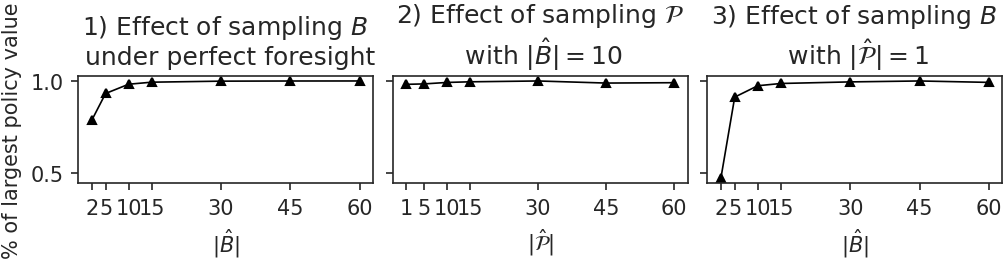

In [186]:
plt.rcParams.update(figsizes.aistats2023_full(nrows=1, ncols=3, height_to_width_ratio=.8))

pf_mean_rews = pf_rews.sum(axis=1).mean(axis=1)
b_mean_rews = b_rews.sum(axis=1).mean(axis=1)
p_mean_rews = p_rews.sum(axis=1).mean(axis=1)

pf_sort_inds = np.argsort(pf_nums)
b_sort_inds = np.argsort(b_nums)
p_sort_inds = np.argsort(p_nums)

pf_percs = pf_mean_rews / pf_mean_rews.max()
p_percs = p_mean_rews / p_mean_rews.max()
b_percs = b_mean_rews / b_mean_rews.max()

pf_nums = np.array(pf_nums)
b_nums = np.array(b_nums)
p_nums = np.array(p_nums)

fig, axs = plt.subplots(ncols=3, sharey=True)

lw = .8
markersize = 4

axs[0].set_ylabel("% of largest policy value")

axs[0].set_xlabel("$|\hat{B}|$")
axs[0].set_xticks(b_nums)
axs[0].set_xticklabels(b_nums)
axs[0].set_title("1) Effect of sampling $B$ \n under perfect foresight")
axs[0].plot(pf_nums[pf_sort_inds], pf_percs[pf_sort_inds], marker="^", lw=lw, markersize=markersize, c="k")

axs[1].set_xlabel("$|\hat{\mathcal{P}}|$")
axs[1].set_xticks(p_nums)
p_labels = list(p_nums)
# p_nums[p_sort_inds]
# p_labels[p_sort_inds][0] = "$1^*$"
axs[1].set_xticklabels(p_labels)
axs[1].set_title("2) Effect of sampling $\mathcal{P}$ \n with $|\hat{B}|=10$")

axs[1].plot(p_nums[p_sort_inds], p_percs[p_sort_inds], marker="^", lw=lw, markersize=markersize, c="k")

axs[2].set_xlabel("$|\hat{B}|$")
axs[2].set_xticks(b_nums)
axs[2].set_xticklabels(b_nums)
axs[2].set_title("3) Effect of sampling $B$ \n with $|\hat{\mathcal{P}}|=1$")

axs[2].plot(b_nums[b_sort_inds], b_percs[b_sort_inds], marker="^", lw=lw, markersize=markersize, c="k")

plt.show()

In [187]:
print(pf_percs[pf_sort_inds])
print(p_percs[p_sort_inds])
print(b_percs[b_sort_inds])

[0.78540649 0.93182158 0.98230735 0.99341433 0.99900169 0.99982889
 1.        ]
[0.98163539 0.98409612 0.99202127 0.99542803 1.         0.98860843
 0.99061119]
[0.47004831 0.91224698 0.97412068 0.98634685 0.99496426 1.
 0.99229616]


### Plot value function to find out how |P| affects policy value

In [188]:
b_num = 10
p_num = 60

BIDS, B, P = mdp.create_sampled_spaces(P_MIN, P_MAX, b_num=b_num, p_num=p_num)
pol = np.load(res_dir + f"pol_STAGES_24_W_1000_k50_R_61_P_{p_num}_B_{b_num}.npy")
V = np.load(res_dir + f"V_STAGES_24_W_1000_k50_R_61_P_{p_num}_B_{b_num}.npy")

In [189]:
import util

V_test = np.zeros((V.shape[0], V.shape[1], V.shape[2], len(BIDS), len(BIDS)))
V_test.shape

for ind1, b_minus in enumerate(BIDS):
    for ind2, b_plus in enumerate(BIDS):
        if b_minus <= b_plus:
            B_ind = util._find_bid_ind((b_minus, b_plus), B)
            V_test[..., ind1, ind2] = V[..., B_ind]

/tmp/ipykernel_41832/3532471449.py:84: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


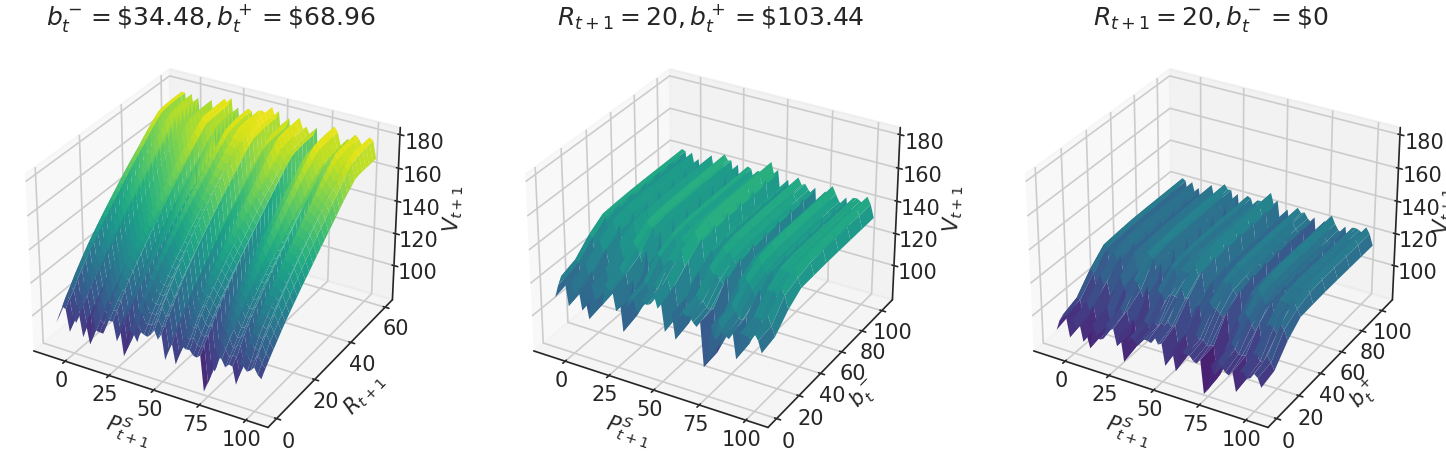

In [191]:
t = 12

cmap = "viridis"
ec = "white"
lw = 0

X_TICK_PADDING = -5
Y_TICK_PADDING = -3
Z_TICK_PADDING = -1

X_LABEL_PADDING = -7
Y_LABEL_PADDING = -7
Z_LABEL_PADDING = -4

fig = plt.figure(figsize=(10, 3.1), constrained_layout=True) # 10, 2.5
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

# SUBPLOT 1
x = P
y = np.arange(0, 61)
x, y = np.meshgrid(x, y)
z = V[t, :, :, 30].T

vmin = V[t, :, :, 30].min()
vmax = V[t, :, :, 30].max()

ax1.set_xlabel("$P_{t+1}^S$", labelpad=X_LABEL_PADDING)
ax1.set_ylabel("$R_{t+1}$", labelpad=Y_LABEL_PADDING)
ax1.set_zlabel("$V_{t+1}$", labelpad=Z_LABEL_PADDING)
ax1.set_title("$b_t^- = \$34.48, b_t^+ = \$68.96$")

ax1.plot_surface(x, y, z, cmap=cmap, vmin=vmin, vmax=vmax, rcount=60, ccount=60, ec=ec, lw=lw)

zlim = ax1.get_zlim()

# SUBPLOT 2
x = P
y = BIDS
x, y = np.meshgrid(x, y)
z = V_test[t, :, 20, :, -1].T

ax2.set_xlabel("$P_{t+1}^S$", labelpad=X_LABEL_PADDING)
ax2.set_ylabel("$b_t^-$", labelpad=Y_LABEL_PADDING)
ax2.set_zlabel("$V_{t+1}$", labelpad=Z_LABEL_PADDING)
ax2.set_title("$R_{t+1} = 20, b_t^+ = \$103.44$")

ax2.plot_surface(x, y, z, cmap=cmap, vmin=vmin, vmax=vmax, rcount=80, ccount=80, ec=ec, lw=lw)

ax2.set_zlim(zlim)

# SUBPLOT 3
x = P
y = BIDS
x, y = np.meshgrid(x, y)
z = V_test[t, :, 20, 0, :].T

ax3.set_xlabel("$P_{t+1}^S$", labelpad=X_LABEL_PADDING)
ax3.set_ylabel("$b_t^+$", labelpad=Y_LABEL_PADDING)
ax3.set_zlabel("$V_{t+1}$", labelpad=Z_LABEL_PADDING - 3)
ax3.set_title("$R_{t+1} = 20, b_t^- = \$0 $")

ax3.plot_surface(x, y, z, cmap=cmap, vmin=vmin, vmax=vmax, rcount=80, ccount=80, ec=ec, lw=lw)

ax3.set_zlim(zlim)

for ax in [ax1, ax2, ax3]:
    xticks = [*ax.xaxis.get_major_ticks(), *ax.xaxis.get_minor_ticks()]
    yticks = [*ax.yaxis.get_major_ticks(), *ax.yaxis.get_minor_ticks()]
    zticks = [*ax.zaxis.get_major_ticks(), *ax.zaxis.get_minor_ticks()]

    for tick in xticks:
        tick.set_pad(X_TICK_PADDING)

    for tick in yticks:
        tick.set_pad(Y_TICK_PADDING)

    for tick in zticks:
        tick.set_pad(Z_TICK_PADDING)


fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# fig.subplots_adjust(left=None)
fig.savefig(fig_dir + "value_function_importance_of_p.png")

plt.show()

## Run NYISO real-time dispatch market experiment
We compare BADP-lattice to perfect foresight.

In [192]:
b_num = 30
p_num = 1

_, B, P = mdp.create_sampled_spaces(P_MIN, P_MAX, b_num=b_num, p_num=p_num)

pol = np.load(f"results_sampling_experiment/pol_STAGES_24_W_1000_k50_R_61_P_{p_num}_B_{b_num}.npy")

In [193]:
# seed set for reproducibility.
test_paths = jdp_.simulate(W_TRAIN, (STAGES + 1) * SETTLEMENTS, p0, freq="5T", last_ts=p0_ts, seed=3000)

In [194]:
dec, act, inv, rew = mdp.simulate_policy(pol, test_paths, p0, P, B)

In [197]:
pol_pf = mdp.perfect_foresight(test_paths, B)

In [198]:
dec_pf, act_pf, inv_pf, rew_pf = mdp.simulate_pf_policy(pol_pf, test_paths)

In [199]:
perc_optimality = (rew.sum(axis=0) / rew_pf.sum(axis=0)).mean()
print(f"BADP-lattice achieves {perc_optimality * 100: .2f}% of perfect foresight policy value.")

BADP-lattice achieves  81.71% of perfect foresight policy value.


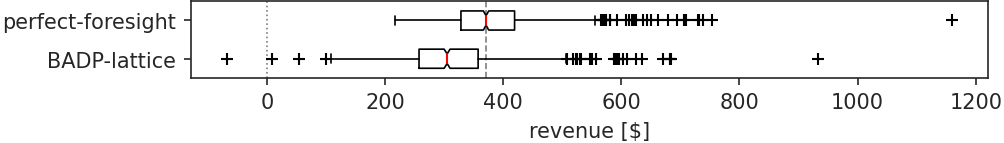

In [200]:
plt.rcParams.update(figsizes.aistats2023_full(nrows=1, ncols=1, height_to_width_ratio=.15))
fig, ax = plt.subplots()


cum_rews = np.vstack([rew.sum(axis=0), rew_pf.sum(axis=0)])
combs = np.arange(cum_rews.shape[0]) + 1

lw = .8

# ax.grid(axis='x', lw=.5)
ax.axvline(np.median(cum_rews[1]), linestyle="dashed", color="tab:gray", lw=lw)
ax.axvline(0, color="tab:gray", lw=lw, ls="dotted")
bp = ax.boxplot(cum_rews.T,
           notch=True,
           sym='k+',
           vert=False,
           widths=.5,
           positions=combs,
           boxprops=dict(lw=lw),
           whiskerprops=dict(lw=lw),
           flierprops=dict(lw=lw),
           capprops=dict(lw=lw))

for median in bp['medians']:
    median.set_color('red')

ax.set_xlabel("revenue [\$]")
ax.set_yticklabels(["BADP-lattice", "perfect-foresight"])

plt.show()

In [203]:
def plot_pol_sim_small(test_paths,
                       dec,
                       act,
                       inv,
                       rew,
                       dec_pf,
                       act_pf,
                       inv_pf,
                       rew_pf,
                       scen,
                       title=None):
    prices = test_paths.iloc[:, scen]

    plt.rcParams.update(figsizes.aistats2023_full(nrows=3, ncols=1, height_to_width_ratio=.22))
    cols = sns.color_palette("colorblind")
    
    lw = 1
    bid_lw = .8
    zero_lw = .5

    arrow_dy = 20
    arrow_width = .2
    arrow_head_width = 2
    arrow_head_length = 7
    arrow_lw = .3

    fig, axs = plt.subplots(3,1, height_ratios=[2, 1, 1], sharex=True)

    xs = np.arange(0, (STAGES + 2) * SETTLEMENTS, 1)
    inv_xs = np.arange(0, (STAGES + 2) * SETTLEMENTS + 1, 1)
    stage_xs = np.arange(0, (STAGES + 2) * SETTLEMENTS, SETTLEMENTS)
    
    axs[0].axhline(0, linestyle="dashed", color="black", lw=zero_lw)
    axs[0].plot(prices.values, label="$P_t$", lw=lw, c=cols[0])

    # sell bid
    sell_bid_col = "k"
    axs[0].hlines(dec[:, scen, 1], xmin=stage_xs[1:-1], xmax=stage_xs[2:], label="sell bid (BADP-lattice)", colors=sell_bid_col, lw=bid_lw)

    for s in range(STAGES):
        if not dec[s, scen, 1] == np.inf:
            arrow_x = (int) ((stage_xs[s + 1] + stage_xs[s + 2]) / 2)
            arrow_y = dec[s, scen, 1]
            axs[0].arrow(arrow_x,
                        arrow_y,
                        0,
                        arrow_dy,
                        width=arrow_width,
                        head_width=arrow_head_width,
                        head_length=arrow_head_length,
                        lw=arrow_lw,
                        color=sell_bid_col)

    # buy bid
    buy_bid_col = cols[3]
    axs[0].hlines(dec[:, scen, 0], xmin=stage_xs[1:-1], xmax=stage_xs[2:], label="buy bid (BADP-lattice)", colors=buy_bid_col, lw=bid_lw)

    for s in range(STAGES):
        arrow_x = (int) ((stage_xs[s + 1] + stage_xs[s + 2]) / 2)
        arrow_y = dec[s, scen, 0]
        axs[0].arrow(arrow_x,
                     arrow_y,
                     0,
                     - arrow_dy,
                     width=arrow_width,
                     head_width=arrow_head_width,
                     head_length=arrow_head_length,
                     lw=arrow_lw,
                     color=buy_bid_col)


    axs[0].set_ylabel("price [\$/MWh]")
    axs[0].legend(loc="lower left")

    for x in stage_xs:
        for ax in axs:
            ax.axvline(x, c="tab:gray", lw=.4)

    axs[1].plot(inv_xs[SETTLEMENTS:-SETTLEMENTS], inv[:, scen] / 12, lw=lw, label="BADP-lattice")
    axs[1].set_ylabel("storage\nlevel [MWh]")
    axs[1].axhline(0, linestyle="dashed", color="black", lw=zero_lw)
    axs[1].legend(loc="upper right")
    axs[1].set_ylim(top=5.1)
    # axs[2].margins(y=2)
    axs[1].set_yticks([0, R_MAX / (2 * 12), R_MAX / 12])
    axs[1].margins(y=.1)

    axs[1].step(inv_xs[SETTLEMENTS:-SETTLEMENTS], inv_pf[:, scen] / 12, lw=lw, label="perfect-foresight", ls=":")
    axs[1].legend(loc="upper right")
    
    axs[2].plot(xs[SETTLEMENTS:-SETTLEMENTS], np.cumsum(rew[:, scen]), label="BADP-lattice", lw=lw)
    axs[2].set_ylabel("cumulative\nreward [\$]")

    axs[2].axhline(0, linestyle="dashed", color="black", lw=zero_lw)

    axs[2].set_xlabel("stage")
    axs[2].set_xticks(stage_xs, labels=np.arange(0, (int) (len(xs) / SETTLEMENTS)))

    axs[2].plot(xs[SETTLEMENTS:-SETTLEMENTS], np.cumsum(rew_pf[:, scen]), label="perfect-foresight", lw=lw, ls=":")
    axs[2].legend(loc="upper left")

    axs[0].margins(x=0)

    fig.savefig(fig_dir + "badp-lattice_sim_small_example.png")
    
    if title:
        fig.suptitle(title)
    plt.show()

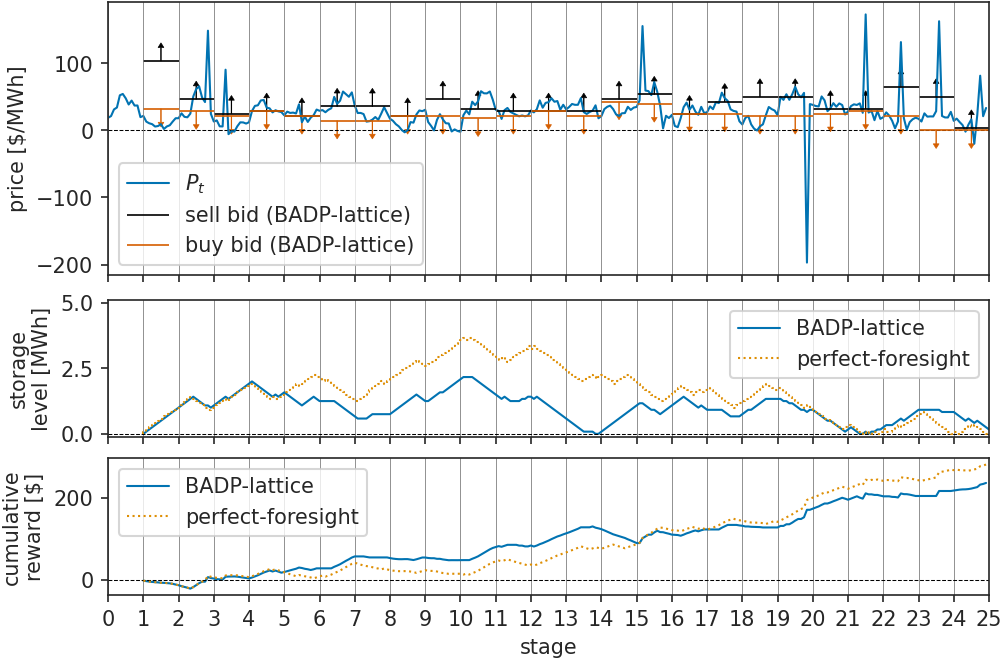

In [204]:
plot_pol_sim_small(test_paths, dec, act, inv, rew, dec_pf, act_pf, inv_pf, rew_pf, 30)

# Poisson Jump Model

In [205]:
from jump_diffusion_process import PoissonJumpProcess

In [206]:
prices = pd.read_csv(f"../dat/OASIS_Day-Ahead_Market_Zonal_LBMP_2021_2022.csv")

prices["time"] = pd.to_datetime(prices.loc[:, "Eastern Date Hour"])

prices = pd.Series(data=prices["DAM Zonal LBMP"].values, index=prices["time"])
prices.index.name = "time"

# deals with daylight savings time
# prices = prices.tz_localize("America/New_York", ambiguous="infer")
prices = prices.tz_localize("EST", ambiguous="infer")

# Sometimes, the last price is corrected before the next interval starts.
# We need to clean this up.
ns5min = 60 * 1000000000   # 5 minutes in nanoseconds
rounded = pd.to_datetime(((prices.index.astype(np.int64) // ns5min) * ns5min))
index = prices.index.copy()
dropthis = []

for ind, val in enumerate(rounded):
    if ind + 1 < len(rounded) and rounded[ind + 1] == val:
        ts = index[ind]
        nxt_ts = index[ind + 1]
        
        prices[ts] = prices[nxt_ts]
        dropthis += [nxt_ts]

prices = prices.drop(dropthis)

In [207]:
pjp = PoissonJumpProcess(lambd=3).fit(prices)

In [208]:
pjp._jdparams

JumpDiffParams(kappa=377.31962548069407, mu=-0.06893107443480195, sigma=0.042085029398891714, mu_j=0.007285736297696602, sigma_j=0.17133584533862542, p_j=3577.961376193819)

In [209]:
pjp._jdparams.p_j / len(prices)

0.20426817630702324

In [210]:
p_start = prices[0]
ts_start = prices.index[0] - pd.Timedelta(hours=1)

paths = pjp.simulate(1000, len(prices), p_start, ts_start, freq="H", seed=3000)

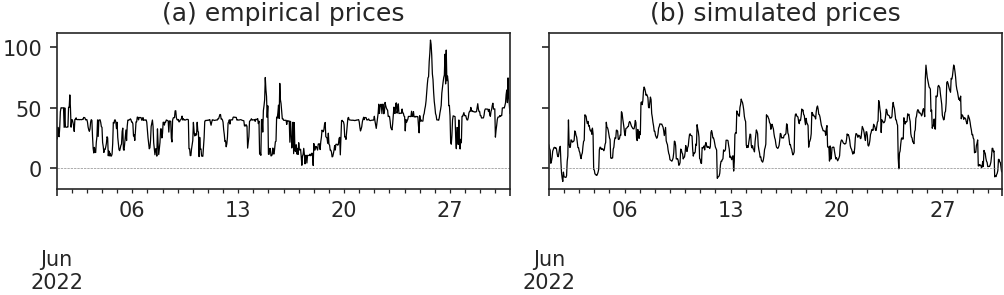

In [223]:
plt.rcParams.update(figsizes.aistats2023_full(nrows=1, ncols=2, height_to_width_ratio=.6))

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)

ind = 150

fr = "2022-6-1"
to = "2022-6-30"

prices.loc[fr:to].plot(lw=.6, ax=axs[0], c="k")
axs[0].set_title("(a) empirical prices")

paths.loc[fr:to, ind].plot(lw=.6, ax=axs[1], legend=False, c="k")
axs[1].set_title("(b) simulated prices")

axs[0].axhline(0, lw=.3, c="tab:gray", ls="dashed")
axs[1].axhline(0, lw=.3, c="tab:gray", ls="dashed")

axs[0].set_xlabel(None)
axs[1].set_xlabel(None)

fig.savefig(fig_dir + "nyiso_da_emp_vs_sim.png")

plt.show()